## HICP Data Analysis

The file `HICPSpain.xlsx` stores the time series of the Harmonised Indices of Consumer Prices (HICP) in Spain from Q1 1996 to Q4 2022. The following code loads the data and creates the time series plot.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA

In [3]:
# Load dataset
file_path = "HICPSpain.xlsx"
df = pd.read_excel(file_path)

In [4]:
# Convert 'Date' to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Extract year and quarter
df["Quarter"] = df["Date"].dt.to_period("Q").astype(str)


print(df.head())

        Date  HICP.All.Spain Quarter
0 1996-01-01           64.34  1996Q1
1 1996-04-01           64.93  1996Q2
2 1996-07-01           65.38  1996Q3
3 1996-10-01           65.64  1996Q4
4 1997-01-01           65.77  1997Q1


In [5]:
df.set_index("Quarter", inplace=True)

In [6]:
print(df)

              Date  HICP.All.Spain
Quarter                           
1996Q1  1996-01-01           64.34
1996Q2  1996-04-01           64.93
1996Q3  1996-07-01           65.38
1996Q4  1996-10-01           65.64
1997Q1  1997-01-01           65.77
...            ...             ...
2021Q4  2021-10-01          111.13
2022Q1  2022-01-01          115.51
2022Q2  2022-04-01          118.22
2022Q3  2022-07-01          117.55
2022Q4  2022-10-01          117.22

[108 rows x 2 columns]


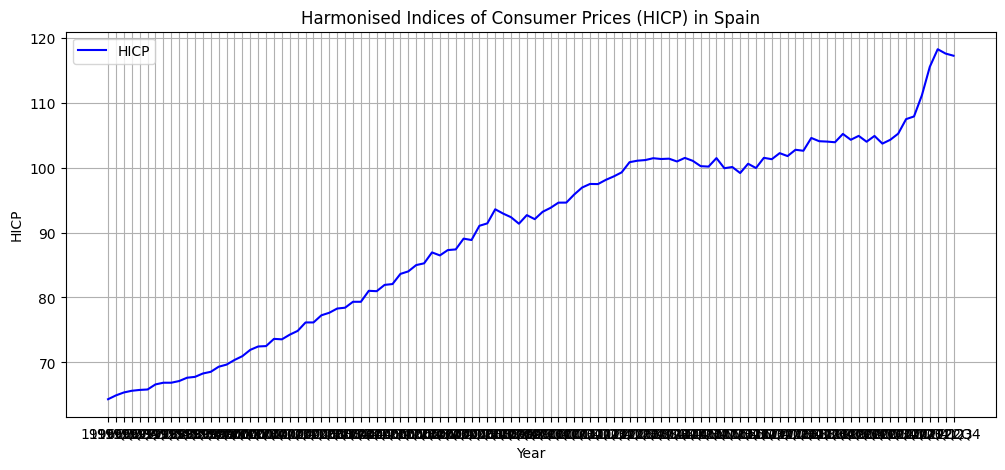

In [21]:
#  Plot Full Time Series ---
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["HICP.All.Spain"], color="blue", label="HICP")
plt.title("Harmonised Indices of Consumer Prices (HICP) in Spain")
plt.xlabel("Year")
plt.ylabel("HICP")
plt.legend()
plt.grid()
plt.show()

<Figure size 1200x500 with 0 Axes>

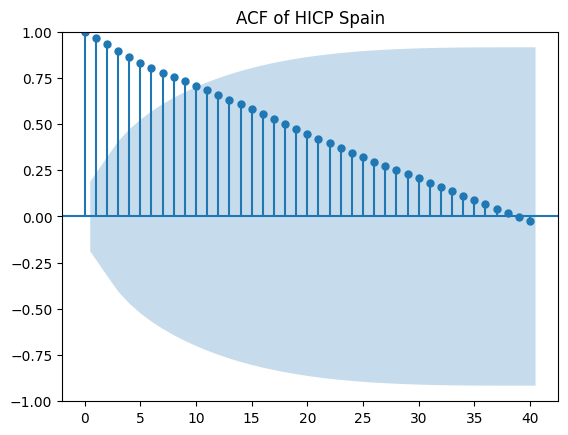

In [23]:
# Plot the ACF of the time series
plt.figure(figsize=(12, 5))
plot_acf(df, lags=40)
plt.title("ACF of HICP Spain")
plt.show()

The following code creates the decompositions of the time series into their trend, seasonal and residual components under the additive and multiplicative model. We set `period=12` since we have monthly data. 

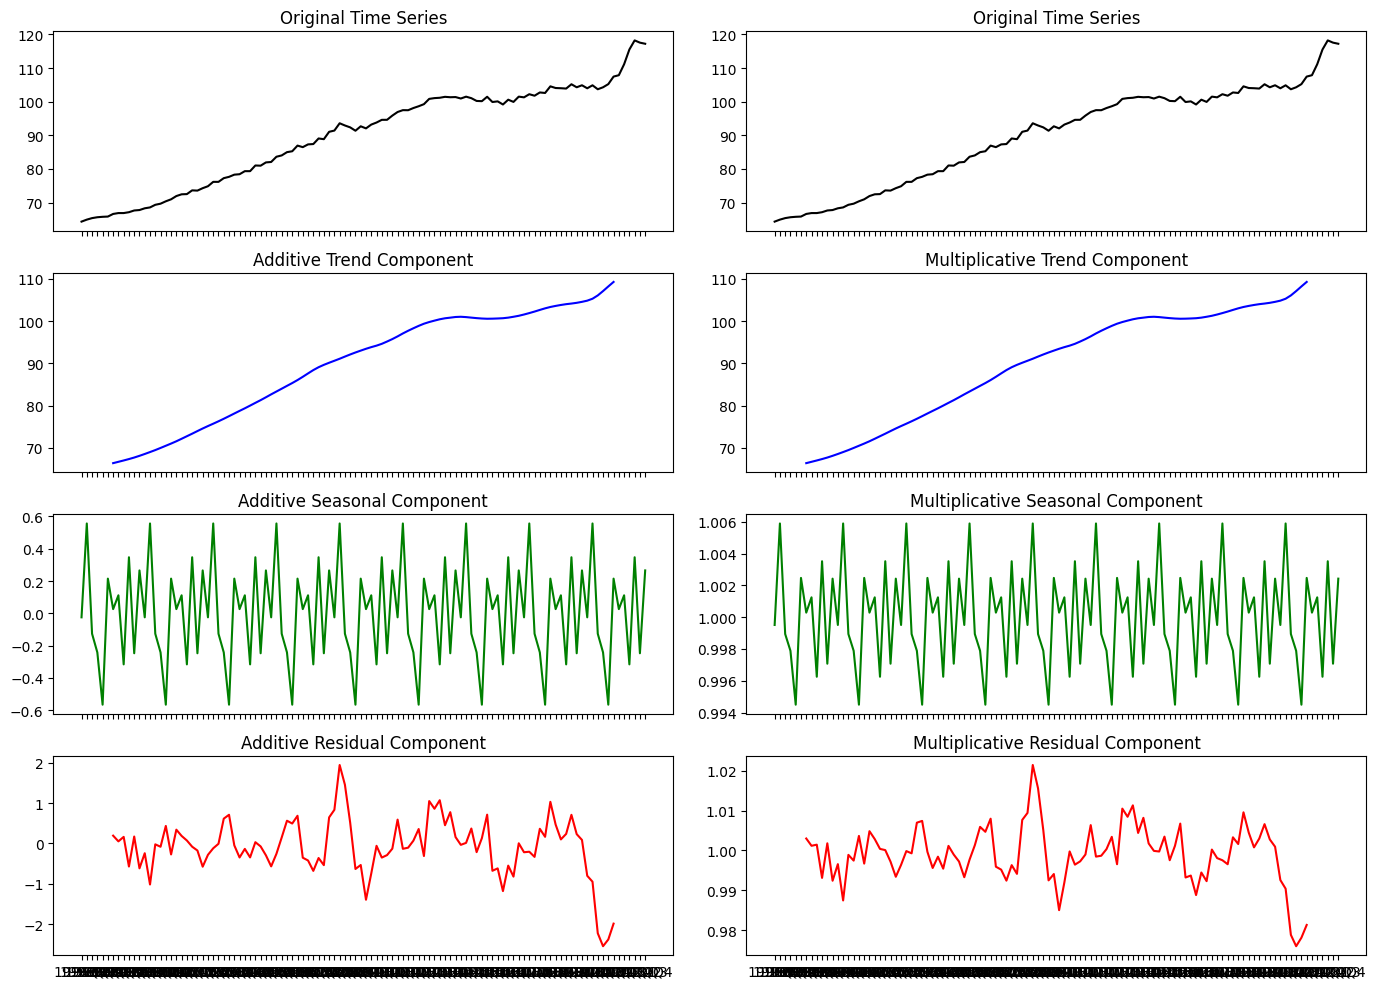

In [24]:

# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(df["HICP.All.Spain"], model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(df["HICP.All.Spain"], model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(df.index, df["HICP.All.Spain"], color="black")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(df.index, additive_decomposition.trend, color="blue")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(df.index, additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(df.index, additive_decomposition.resid, color="red")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(df.index, df["HICP.All.Spain"], color="black")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(df.index, multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(df.index, multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(df.index, multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()


We next ask ourselves if the residuals of the additive decomposition are stationary. If not, it means that there are additional patterns in the data that the decomposition did not pick up. What does the p-value tell us?

In [25]:
# --- Perform ADF Test on Residuals (Assuming Additive is Best) ---
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")


ADF Statistic: -3.5355
p-value: 0.0071


We also compute the ACF and PACF to check if the residuals are white noise (the ACF would be sufficient, this is to show you how to compute the PACF). What do we observe?

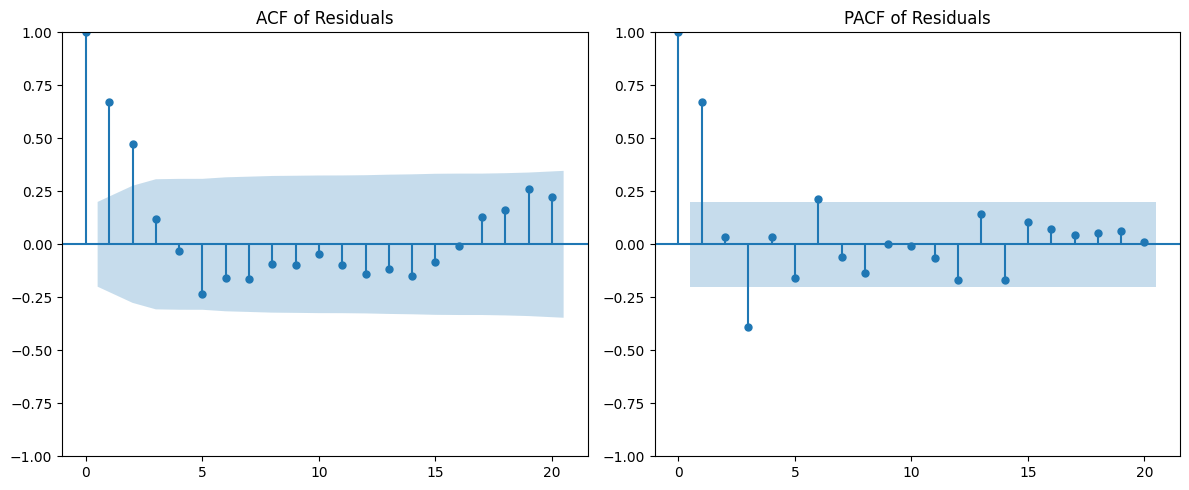

In [26]:
# ---  ACF and PACF Plots of Residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(residuals, lags=20, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(residuals, lags=20, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()


Last, we use the Ljung-Box test, checking if the first 20 autocorrelations are all zero. What does the p-value tell us?

In [27]:
# --- Perform Ljung-Box Test ---
ljungbox_result = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljungbox_result["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")



Ljung-Box p-value: 0.0000


Exponential smoothing and compare the last 12 months prediction with the actual data.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Split the dataset: exclude the last 12 months for training
train_data = df.iloc[:-12]  # Use all but the last 12 months for training
test_data = df.iloc[-12:]   # Last 12 months for testing

# Fit Holt-Winters Exponential Smoothing model (seasonal period = 12 for monthly data)
hw_model = ExponentialSmoothing(
    train_data["Unemployment"],
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit()




## ARIMA Model

In [37]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an AR(1) model (i.e., ARIMA(1, 0, 0))
ar1_model = sm.tsa.ARIMA(df["HICP_diff"], order=(4, 0, 4)).fit()


# Print the model summary
print(ar1_model.summary())

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

                               SARIMAX Results                                
Dep. Variable:              HICP_diff   No. Observations:                  107
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -114.503
Date:                Fri, 28 Feb 2025   AIC                            249.005
Time:                        15:31:26   BIC                            275.734
Sample:                    04-01-1996   HQIC                           259.841
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4842      0.121      4.003      0.000       0.247       0.721
ar.L1          0.0208      0.201      0.103      0.918      -0.374       0.415
ar.L2          0.2139      0.146      1.466      0.1

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
df["HICP_diff"] = df["HICP.All.Spain"].diff()

In [8]:
df = df.dropna()
print(df)

              Date  HICP.All.Spain  HICP_diff
Quarter                                      
1996Q2  1996-04-01           64.93       0.59
1996Q3  1996-07-01           65.38       0.45
1996Q4  1996-10-01           65.64       0.26
1997Q1  1997-01-01           65.77       0.13
1997Q2  1997-04-01           65.84       0.07
...            ...             ...        ...
2021Q4  2021-10-01          111.13       3.26
2022Q1  2022-01-01          115.51       4.38
2022Q2  2022-04-01          118.22       2.71
2022Q3  2022-07-01          117.55      -0.67
2022Q4  2022-10-01          117.22      -0.33

[107 rows x 3 columns]


In [ ]:
# Fit an AR(1) model (i.e., ARIMA(1, 0, 0))
ar1_model = sm.tsa.ARIMA(df["HICP_diff"], order=(1, 0, 0)).fit()


# Print the model summary
print(ar1_model.summary())

                               SARIMAX Results                                
Dep. Variable:              HICP_diff   No. Observations:                  107
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -141.978
Date:                Mon, 03 Mar 2025   AIC                            289.957
Time:                        09:53:09   BIC                            297.975
Sample:                    04-01-1996   HQIC                           293.207
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4943      0.100      4.958      0.000       0.299       0.690
ar.L1         -0.0180      0.072     -0.248      0.804      -0.160       0.124
sigma2         0.8319      0.101      8.211      0.0

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

<Figure size 1200x500 with 0 Axes>

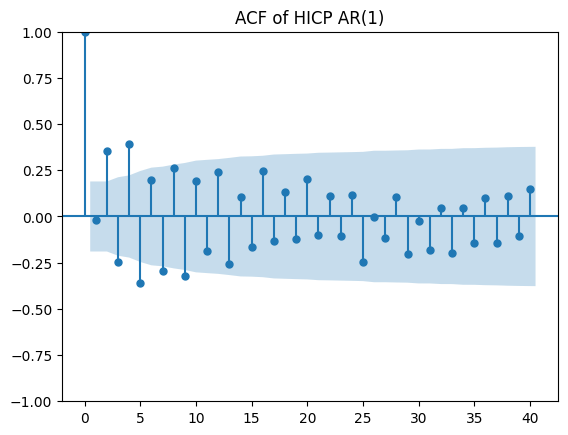

In [34]:
# Plot the ACF of AR(1)
plt.figure(figsize=(12, 5))
plot_acf(df['HICP_diff'], lags=40)
plt.title("ACF of HICP AR(1)")
plt.show()

<Figure size 1200x500 with 0 Axes>

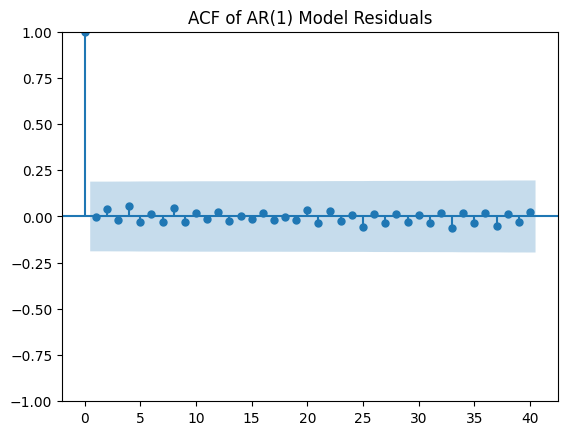

In [32]:
# Get residuals from the AR(1) model
residuals = ar1_model.resid

# Plot ACF of residuals
plt.figure(figsize=(12,5))
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of AR(1) Model Residuals")
plt.show()

In [33]:
ljung_box_results = acorr_ljungbox(residuals, lags=[20], return_df=True)
p_value_ljungbox = ljung_box_results["lb_pvalue"].values[0]

print(f"Ljung-Box p-value: {p_value_ljungbox:.4f}")


Ljung-Box p-value: 1.0000


In [35]:
# List to store results for each AR(p) model
results = []

# Fit AR(p) models for p = 1 to 10 and record AIC and BIC
for p in range(1, 21):
    model = ARIMA(df['HICP.All.Spain'], order=(p, 0, 0))
    res = model.fit()
    results.append({'p': p, 'AIC': res.aic, 'BIC': res.bic})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the table of AIC and BIC values
print(results_df)

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

     p         AIC         BIC
0    1  324.583434  332.601921
1    2  321.685684  332.376999
2    3  295.405865  308.770009
3    4  293.273200  309.310173
4    5  273.881336  292.591137
5    6  266.205955  287.588586
6    7  266.742380  290.797840
7    8  267.888263  294.616551
8    9  268.586755  297.987872
9   10  270.504830  302.578776
10  11  272.391135  307.137910
11  12  268.805457  306.225060
12  13  270.540917  310.633350
13  14  272.532829  315.298090
14  15  273.641348  319.079438
15  16  273.415453  321.526372
16  17  273.760730  324.544478
17  18  269.495631  322.952207
18  19  277.171398  333.300803
19  20  278.833079  337.635314


/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ar(6) model

In [12]:
ar6_model = sm.tsa.ARIMA(df["HICP_diff"], order=(6, 0, 0)).fit()


# Print the model summary
print(ar6_model.summary())

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

                               SARIMAX Results                                
Dep. Variable:              HICP_diff   No. Observations:                  107
Model:                 ARIMA(6, 0, 0)   Log Likelihood                -114.586
Date:                Mon, 03 Mar 2025   AIC                            245.173
Time:                        09:55:50   BIC                            266.556
Sample:                    04-01-1996   HQIC                           253.841
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4714      0.106      4.428      0.000       0.263       0.680
ar.L1          0.3403      0.128      2.651      0.008       0.089       0.592
ar.L2          0.1144      0.095      1.204      0.2

/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/lijustin/Documents/IE/PDAI/.conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWar

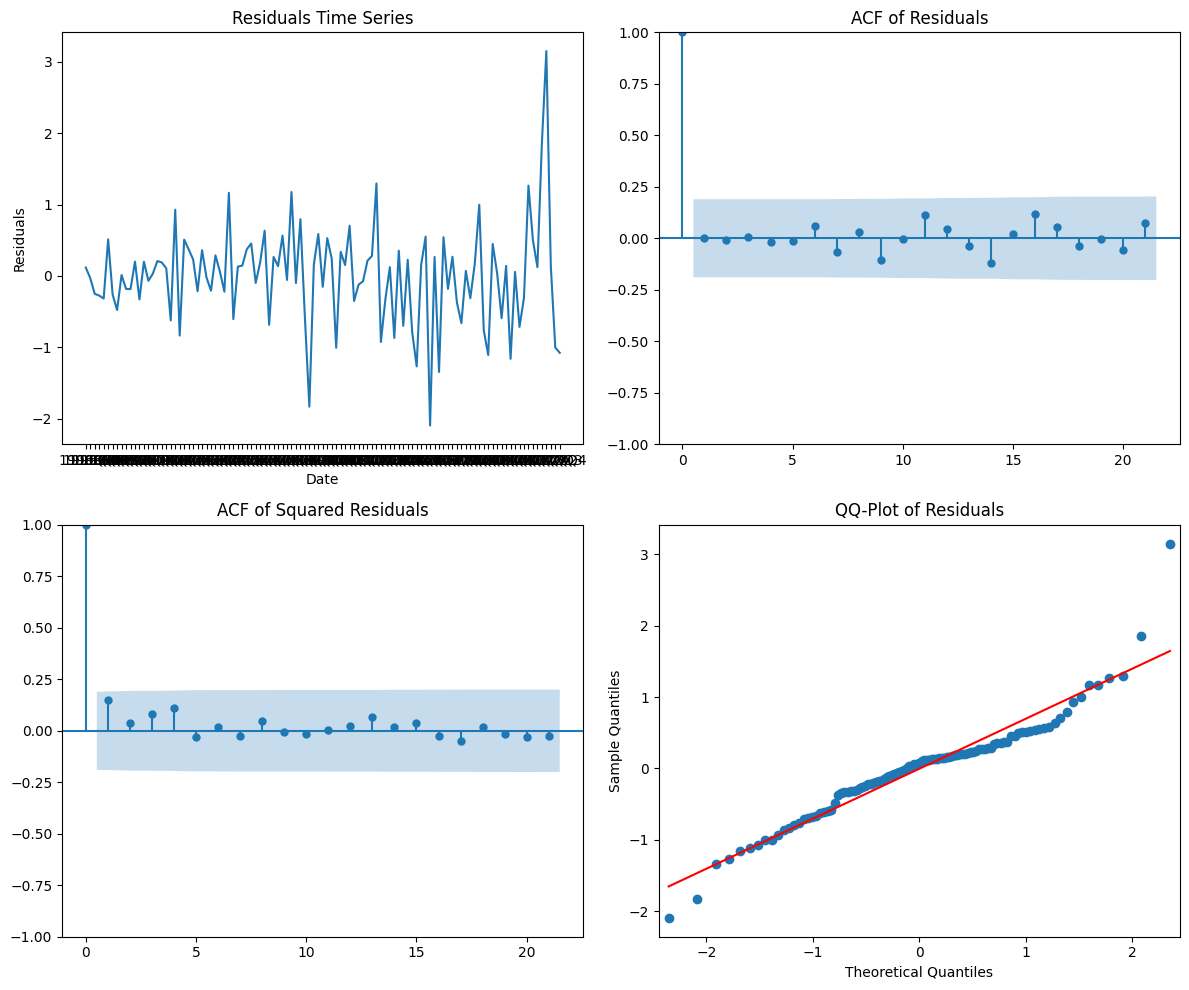

In [11]:
model = ARIMA(df['HICP_diff'], order=(6, 0, 0))
results = model.fit()
resid = results.resid

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Time series plot of the residuals
axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# 2. ACF plot of the residuals
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# 3. ACF plot of the squared residuals
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# 4. QQ-plot of the residuals
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

1 year prediction

In [19]:
df.index = pd.PeriodIndex(df.index.astype(str), freq="Q")


In [20]:
train = df[df.index < pd.Period("2015Q1", freq="Q")]  # Training set: before 2015
test = df[(df.index >= pd.Period("2015Q1", freq="Q")) & (df.index <= pd.Period("2020Q4", freq="Q"))]  # Test set: 2015-2020
train_plot = df[(df.index >= pd.Period("2010Q1", freq="Q")) & (df.index <= pd.Period("2020Q4", freq="Q"))]  # Data for plotting: 2010-2020

In [21]:
# Fit an AR(6) model on the training data
model = ARIMA(train['HICP_diff'], order=(6, 0, 0))
results = model.fit()

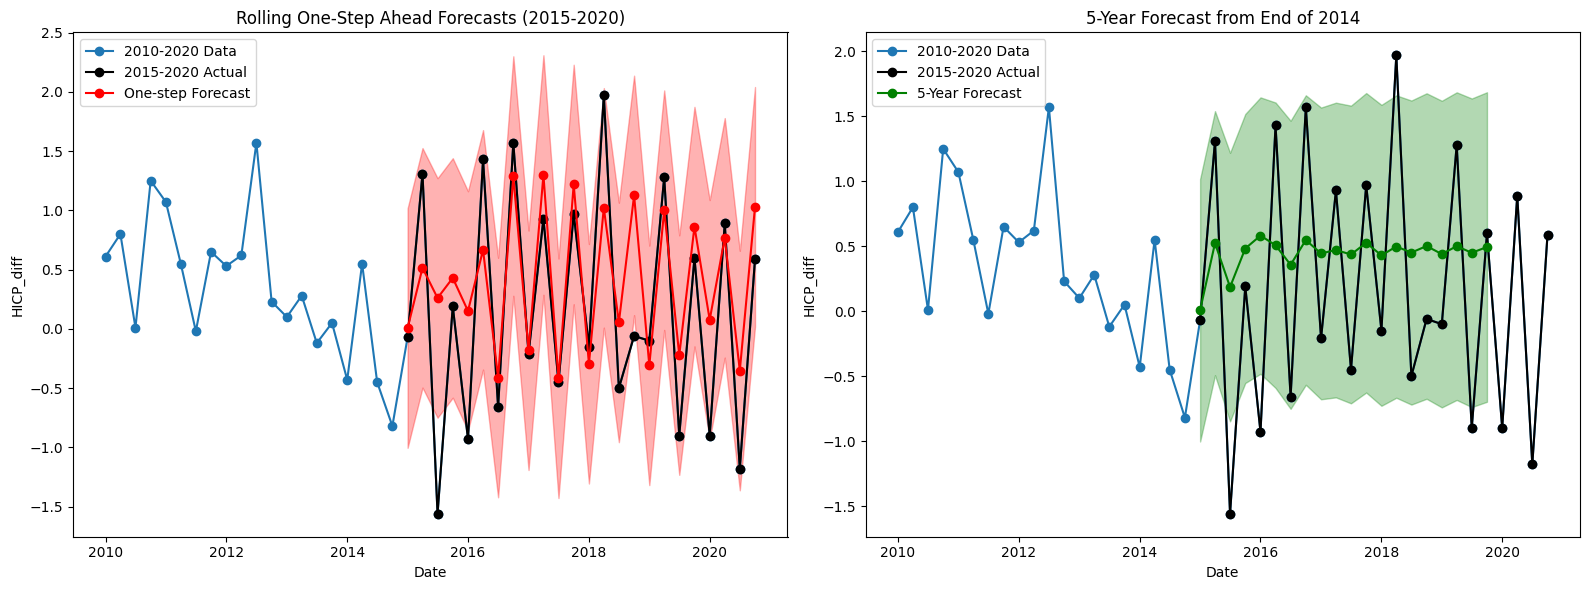

In [28]:
# 5-year forecast from the end of 2014 (static forecast)
forecast_res = results.get_forecast(steps=20)  # 20 quarters = 5 years
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Rolling one-step ahead forecasts for 2015-2020 using the .append() method.
current_results = results  # Use the fitted results directly
one_step_forecasts = []
one_step_ci_lower = []
one_step_ci_upper = []

for date in test.index:
    # Forecast one step ahead using the current state of the model
    forecast_obj = current_results.get_forecast(steps=1)
    forecast_value = forecast_obj.predicted_mean.iloc[0]
    ci = forecast_obj.conf_int()
    one_step_forecasts.append(forecast_value)
    one_step_ci_lower.append(ci.iloc[0, 0])
    one_step_ci_upper.append(ci.iloc[0, 1])

    # Ensure the test data being appended maintains the same format as train
    new_obs = test.loc[[date], ['HICP_diff']].copy()  # Select only the necessary column
    new_obs.index = pd.PeriodIndex(new_obs.index.astype(str), freq="Q")  # Ensure correct freq
    current_results = current_results.append(new_obs, refit=False)  # Append only relevant column

# Convert forecast lists to Series with same index as test
one_step_forecasts = pd.Series(one_step_forecasts, index=test.index)
one_step_ci_lower = pd.Series(one_step_ci_lower, index=test.index)
one_step_ci_upper = pd.Series(one_step_ci_upper, index=test.index)

# Convert PeriodIndex to DatetimeIndex for plotting
train_plot.index = train_plot.index.to_timestamp()
test.index = test.index.to_timestamp()
one_step_forecasts.index = one_step_forecasts.index.to_timestamp()
forecast_mean.index = forecast_mean.index.to_timestamp()
forecast_ci.index = forecast_ci.index.to_timestamp()

# Create two side-by-side plots (showing only 2015-2020 on x-axis)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Rolling one-step ahead forecasts for 2015-2020
axes[0].plot(train_plot.index, train_plot['HICP_diff'], label='2010-2020 Data', marker='o')
axes[0].plot(test.index, test['HICP_diff'], label='2015-2020 Actual', color='black', marker='o')
axes[0].plot(one_step_forecasts.index, one_step_forecasts, label='One-step Forecast', color='red', marker='o')
axes[0].fill_between(one_step_forecasts.index, one_step_ci_lower, one_step_ci_upper, color='red', alpha=0.3)
axes[0].set_title("Rolling One-Step Ahead Forecasts (2015-2020)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("HICP_diff")
axes[0].legend()

# Right plot: 5-year ahead forecast from the end of 2014
axes[1].plot(train_plot.index, train_plot['HICP_diff'], label='2010-2020 Data', marker='o')
axes[1].plot(test.index, test['HICP_diff'], label='2015-2020 Actual', color='black', marker='o')
axes[1].plot(forecast_mean.index, forecast_mean, label='5-Year Forecast', color='green', marker='o')
axes[1].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.3)
axes[1].set_title("5-Year Forecast from End of 2014")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("HICP_diff")
axes[1].legend()

plt.tight_layout()
plt.show()